# CNN Model for SVHN Dataset 32 x 32 Images

Classifying SVHN dataset by using CNN

Student: Ann-Dragon

Project: Street View House Numbers Dataset (2019 Assignment)

Submission date: 27/08/19

In [ ]:
# Importing libraries
from __future__ import absolute_import
from __future__ import print_function
import os
import time
from datetime import timedelta
import h5py
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
c
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import imageio

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 5.0) # Set default figure size

In [2]:
TENSORBOARD_SUMMARIES_DIR = '/tmp/svhn_classifier_logs'

In [3]:
def get_data():
    """Read in and format data from .h5 file"""
    # Open the file as readonly
    h5f = h5py.File('data/SVHN_grey.h5', 'r')
    # Load the training, test and validation set
    X_train = h5f['X_train'][:]
    y_train = h5f['y_train'][:]
    X_test = h5f['X_test'][:]
    y_test = h5f['y_test'][:]
    X_val = h5f['X_val'][:]
    y_val = h5f['y_val'][:]
    # Close this file
    h5f.close()
    print('Training set', X_train.shape, y_train.shape)
    print('Validation set', X_val.shape, y_val.shape)
    print('Test set', X_test.shape, y_test.shape)
    return X_train, y_train, X_test, y_test, X_val, y_val

In [4]:
def plot_images(images, nrows, ncols, cls_true, cls_pred=None):
    """ Plot nrows * ncols images from images and annotate the images
    """
    # Initialize the subplotgrid
    fig, axes = plt.subplots(nrows, ncols)
    # Randomly select nrows * ncols images
    rs = np.random.choice(images.shape[0], nrows*ncols)
    # For every axes object in the grid
    for i, ax in zip(rs, axes.flat): 
        # Predictions are not passed
        if cls_pred is None:
            title = "True: {0}".format(np.argmax(cls_true[i]))
        # When predictions are passed, display labels + predictions
        else:
            title = "True: {0}, Pred: {1}".format(np.argmax(cls_true[i]), cls_pred[i])  
        # Display the image
        ax.imshow(images[i,:,:,0], cmap='binary')
        # Annotate the image
        ax.set_title(title)
        # Do not overlay a grid
        ax.set_xticks([])
        ax.set_yticks([])

In [5]:
def prepare_log_dir():
    '''Clears the log files then creates new directories to place
        the tensorbard log file.''' 
    if tf.gfile.Exists(TENSORBOARD_SUMMARIES_DIR):
        tf.gfile.DeleteRecursively(TENSORBOARD_SUMMARIES_DIR)
    tf.gfile.MakeDirs(TENSORBOARD_SUMMARIES_DIR)

In [6]:
def get_batch(X, y, batch_size=512):
    """Get batches dynamically.
    
    Accounts for the final batch being potentially smaller.
    """
    for i in np.arange(0, y.shape[0], batch_size):
        end = min(X.shape[0], i + batch_size)
        yield(X[i:end],y[i:end])

## CNN Architecture function

`INPUT -> [CONV -> RELU -> CONV -> RELU -> POOL] -> DROPOUT -> [FC -> RELU] -> FC`

In [29]:
def cnn_model_fn(features, discard_rate):
    """Model function for CNN."""
    # Input Layer
    input_layer = tf.reshape(features, [-1, 32, 32, 1], name='Reshaped_Input')

    # Convolutional Layer #1
    conv1 = tf.layers.conv2d(
        inputs=input_layer,
        filters=32,
        kernel_size=[5, 5],
        padding="same",
        activation=tf.nn.relu)

    # Pooling Layer #1
    pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

    # Convolutional Layer #2 and Pooling Layer #2 
    conv2 = tf.layers.conv2d(
          inputs=pool1,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
        
    pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #3 and Pooling Layer #3
    conv3 = tf.layers.conv2d(
          inputs=pool2,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
        
    pool3 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
    
    # Convolutional Layer #4 and Pooling Layer #4 
    conv4 = tf.layers.conv2d(
          inputs=pool3,
          filters=64,
          kernel_size=[5, 5],
          padding="same",
          activation=tf.nn.relu)
        
    pool4 = tf.layers.max_pooling2d(inputs=conv3, pool_size=[2, 2], strides=2)
  
    # Dense Layer
    pool4_flat = tf.reshape(pool4, [-1, 4 * 4 * 64])
    dense = tf.layers.dense(inputs=pool4_flat, units=256, activation=tf.nn.relu)
    dropout = tf.layers.dropout(
         inputs=dense, rate=discard_rate)

    # Logits Layer
    logits = tf.layers.dense(inputs=dropout, units=10)
    return logits

In [30]:
def create_placeholders(X_train):
    """Create variable placeholders."""
    # Using placeholder var whose value can directly feed to the graph
    tf.logging.set_verbosity(tf.logging.INFO)
    # Our application logic will be added here
    x = tf.placeholder(tf.float32, shape = [None, 32, 32, 1], name='Input_Data')
    y = tf.placeholder(tf.float32, shape = [None, 10], name='Input_Labels')
    y_cls = tf.argmax(y, 1)
    discard_rate = tf.placeholder(tf.float32, name='Discard_rate')
    os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
    return x, y, y_cls, discard_rate

In [31]:
def specify_model_and_optimizer(x, y, discard_rate):
    """Specify architecture and operations.
    
    Loss calculated for each iteration using prediction
    from cnn_model_fn() function.
    """
    prediction = cnn_model_fn(x, discard_rate)
    prediction_cls = tf.argmax(prediction, 1)
    loss = tf.reduce_mean(tf.losses.softmax_cross_entropy(
                          onehot_labels=y, logits=prediction), name='loss')
    optimizer = tf.train.AdamOptimizer().minimize(loss)
    return prediction, prediction_cls, loss, optimizer

In [32]:
def accuracy_operations(prediction_cls, y_cls):
    """Calculate total prediction and also calculate accuracy of passed data."""
    # Predicted class equals the true class of each image?
    correct_prediction = tf.equal(prediction_cls, y_cls)
    # Cast predictions to float and calculate the mean
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
    return correct_prediction, accuracy

## Tensorflow Session

In [33]:
def create_session_and_saver():
    """Create session, initialise variables and create Saver object."""
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    # Used for storing and retrieving variables pesent in graph
    saver = tf.train.Saver()
    save_dir = 'checkpnts/'
    # Create directory if it does not exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    save_path = os.path.join(save_dir, 'svhn_single_greyscale')
    return sess, saver, save_path

In [34]:
def run_training(X_train, y_train,
                 X_test, y_test,
                 X_val, y_val,
                 sess,
                 optimizer,
                 accuracy,
                 loss,
                 correct_prediction,
                 discard_rate,
                 x,
                 y):
    """Train model."""
    max_epochs = 4
    # No of examples in each batch for updating weights
    batch_size = 512
    # Discard or fuse % of neurons in train mode
    discard_per = 0.8
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    start_time = time.time()
    for epoch in range(max_epochs):
        print ('Training .........')
        epoch_loss = 0
        print ()
        print ('Epoch ', epoch+1 , ': ........ \n')
        step = 0   
        # Training epochs ....
        for (epoch_x , epoch_y) in get_batch(X_train, y_train, batch_size):
            _, train_accu, c = sess.run([optimizer, accuracy, loss],
                                        feed_dict={x: epoch_x, y: epoch_y,
                                                   discard_rate: discard_per})
            step += 1
            # Get training acurracy and loss at the end of each batch - this
            # will be plotted against the validation acc/loss.
            if (step%1 == 0):
                train_accuracy = train_accu
                print ("Step:", step, ".....", "\nMini-batch training loss: ", c)
                print('Mini-batch training accuracy:' , train_accuracy * 100, '%')
                train_loss_list.append(c)
                train_acc_list.append(train_accuracy)
                # Validating prediction and summaries
                accu = 0.0
                valid_batch_loss_list = []
                valid_batch_acc_list = []
                for (epoch_x , epoch_y) in get_batch(X_val, y_val, 512):
                    correct, _c = sess.run([correct_prediction, loss], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
                    valid_batch_loss_list.append(_c)
                    validation_accuracy = np.sum(correct[correct == True])
                    valid_batch_acc_list.append(validation_accuracy)
                # Can use mean as batches are all the same size
                validation_accuracy = np.sum(valid_batch_acc_list) / len(y_val)
                valid_acc_list.append(validation_accuracy)
                validation_loss = np.mean(valid_batch_loss_list)
                valid_loss_list.append(validation_loss)
                print ('Validation loss: {}'.format(validation_loss))
                print('Validation accuracy:' , validation_accuracy * 100, '%') 
        print ('Epoch', epoch+1, 'completed out of ', max_epochs)
    # Testing prediction and summaries
    correct_list = []
    for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512): 
        correct = sess.run([correct_prediction], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
        correct_list.append(np.sum(correct))
    print('Test Accuracy:' , np.sum(correct_list) * 100.0 / y_test.shape[0], '%')
    # Calculate net time
    time_diff = time.time() - start_time
    print("Time usage: " + str(timedelta(seconds=int(round(time_diff)))))
    return train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, sess, x, y

In [35]:
def performance_testing(sess, X_train, y_train, X_test, y_test, prediction_cls, x, y, discard_rate):
    """Analyse test data and run performance metrics."""
    # Plot 3 rows x 6 cols images randomly with their true labels
    print ('\nA selection of images with their true labels:\n')
    plot_images(X_train, 3, 6, y_train)
    plt.show()
    test_pred = []
    for (epoch_x , epoch_y) in get_batch(X_test, y_test, 512):
        correct = sess.run([prediction_cls], feed_dict={x: epoch_x, y: epoch_y, discard_rate: 0.0})
        test_pred.append((np.asarray(correct, dtype=int)).T)
    
    def flatten(lists):
        """Flatten lists."""
        results = []
        for numbers in lists:
            for x in numbers:
                results.append(x)
        return np.asarray(results)
    flat_array = flatten(test_pred)
    flat_array = flatten(test_pred)
    flat_array = (flat_array.T)
    flat_array = flat_array[0]
    
    # *** Calculate F1 scores ***
    # y_true and y_pred are the flat vectors of classes that correspond to each other
    # i.e. the first entry in y_true is the actaul class of image 1 while y_pred is the predicted class
    # These can be used for the calculation of F1 scores
    # Convert the actual and predicted classes to dataframe
    y_true=np.argmax(y_test, axis=1)
    results = pd.DataFrame({'Actual': y_true, 'Predicted': flat_array})
    
    def calculate_f1_score_per_class(df, number):
        """Get F1 score for each class."""
        tp = len(df[(df['Predicted'] == number) & (df['Actual'] == number)])
        fp = len(df[(df['Predicted'] == number) & (df['Actual'] != number)])
        fn = len(df[(df['Predicted'] != number) & (df['Actual'] == number)])
        try:
           precision = tp / len(df[df['Predicted'] == number])
           recall = tp / len(df[df['Actual'] == number])
           f1 = 2 * (precision * recall) / (precision + recall)
        except ZeroDivisionError:
            f1 = precision = recall = 999
        return f1
    # Get the f1 scores for each class as a list of tuples
    f1_scores = []
    for number in set(results['Actual']):
        tup = (number, round(calculate_f1_score_per_class(results, number),3))
        f1_scores.append(tup)
    print ('\nF1 Scores for each class follow:\n')
    print (f1_scores)
    return f1_scores, y_test, flat_array, prediction_cls

### Plotting Learning Curves
Plot training and validation curves to analyse whether model will generalise well.
Is under or over-fitting evident?

In [36]:
def plot_learning_curves(train_acc_list,
                         valid_acc_list,
                         train_loss_list,
                         valid_loss_list
                        ):
    """Plot learning curves to check for under/over-fitting."""
    # Learning Curve (Accuracy)
    plt.plot(train_acc_list ,'r', label='Training Curve')
    plt.plot(valid_acc_list, 'g', label='Validation Curve')
    plt.legend(loc='lower right')
    plt.title('Learning Curve (Accuracy) for Convolutional Neural Net (SHVN Dataset)')
    plt.xlabel('No. of batches')
    plt.ylabel('Accuracy (%)')
    plt.show()

    # Learning Curve (Loss)
    plt.plot(train_loss_list ,'r', label='Training Curve')
    plt.plot(valid_loss_list, 'g', label='Validation Curve')
    plt.legend(loc='upper right')
    plt.title('Learning Curve (Loss) for Convolutional Neural Net (SHVN Dataset)')
    plt.xlabel('No. of batches')
    plt.ylabel('Loss')
    plt.show()

In [37]:
def create_confusion_matrix(y_test, flat_array):
    # ***Get confusion matrix - see misclassifications by model***
    # Set the figure size
    plt.figure(figsize=(10, 6))
    # argmax is used to return the position of the largest value for each y_test class
    # i.e. it finds the index of the 1 in a vector such as [0,0,0,0,0,1,0,0,0,0] i.e. 5
    # which corresponds to the value of the class.
    cm = confusion_matrix(y_true=np.argmax(y_test, axis=1), y_pred=flat_array)
    # Normalize the confusion matrix
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100.0
    # Visualize the confusion matrix
    ax = plt.axes()
    sns.heatmap(cm, annot=True, cmap='Reds', fmt='.1f', square=True, ax=ax)
    ax.set_title('10-class Confusion Matrix (SVHN Images)')
    plt.show()

### Load saved Tensorflow model & predict house number from test image.
Load the tensorflow graph and variables from archive/use model to predict most likely number.

In [38]:
def traintest():
    """Main function for reading in train/test data,
       training model and analysing test data.
    """
    X_train, y_train, X_test, y_test, X_val, y_val = get_data()
    x, y, y_cls, discard_rate = create_placeholders(X_train)
    prepare_log_dir()
    prediction, prediction_cls, loss, optimizer = specify_model_and_optimizer(x, y, discard_rate)
    correct_prediction, accuracy = accuracy_operations(prediction_cls, y_cls)
    sess, saver, save_path = create_session_and_saver()
    
    #X_train = X_train[0:512*20]
    #X_test = X_test[0:512*20]
    #y_train = y_train[0:512*20]
    #y_test = y_test[0:512*20]
    
    train_acc_list, train_loss_list, valid_acc_list, valid_loss_list, sess, x, y = \
        run_training(X_train, y_train,
                     X_test, y_test,
                     X_val, y_val,
                     sess,
                     optimizer,
                     accuracy,
                     loss,
                     correct_prediction,
                     discard_rate,
                     x,
                     y
                    )
    saver.save(sess=sess, save_path=save_path)
    f1_scores, y_test, flat_array, prediction_cls = performance_testing(sess, X_train, y_train, X_test, y_test, prediction_cls, x, y, discard_rate)
    plot_learning_curves(train_acc_list, valid_acc_list, train_loss_list, valid_loss_list)
    create_confusion_matrix(y_test, flat_array)
    return prediction_cls

Training set (58605, 32, 32, 1) (58605, 10)
Validation set (14652, 32, 32, 1) (14652, 10)
Test set (26032, 32, 32, 1) (26032, 10)
Training .........

Epoch  1 : ........ 

Step: 1 ..... 
Mini-batch training loss:  2.3013859
Mini-batch training accuracy: 8.984375 %
Validation loss: 2.253263235092163
Validation accuracy: 20.256620256620256 %
Step: 2 ..... 
Mini-batch training loss:  2.2796073
Mini-batch training accuracy: 19.7265625 %
Validation loss: 2.2377991676330566
Validation accuracy: 19.492219492219494 %
Step: 3 ..... 
Mini-batch training loss:  2.2438567
Mini-batch training accuracy: 18.75 %
Validation loss: 2.2369048595428467
Validation accuracy: 19.403494403494403 %
Step: 4 ..... 
Mini-batch training loss:  2.2377355
Mini-batch training accuracy: 19.140625 %
Validation loss: 2.232417106628418
Validation accuracy: 19.403494403494403 %
Step: 5 ..... 
Mini-batch training loss:  2.2468872
Mini-batch training accuracy: 16.40625 %
Validation loss: 2.2284903526306152
Validation accura

Step: 48 ..... 
Mini-batch training loss:  1.0157665
Mini-batch training accuracy: 69.3359375 %
Validation loss: 0.9471182227134705
Validation accuracy: 70.33852033852034 %
Step: 49 ..... 
Mini-batch training loss:  0.88142645
Mini-batch training accuracy: 73.6328125 %
Validation loss: 0.9574488401412964
Validation accuracy: 69.4034944034944 %
Step: 50 ..... 
Mini-batch training loss:  1.0018806
Mini-batch training accuracy: 68.1640625 %
Validation loss: 0.8999470472335815
Validation accuracy: 71.65574665574665 %
Step: 51 ..... 
Mini-batch training loss:  0.92766905
Mini-batch training accuracy: 69.140625 %
Validation loss: 0.8572900295257568
Validation accuracy: 73.67594867594867 %
Step: 52 ..... 
Mini-batch training loss:  0.92317474
Mini-batch training accuracy: 74.21875 %
Validation loss: 0.8604182004928589
Validation accuracy: 73.64182364182365 %
Step: 53 ..... 
Mini-batch training loss:  0.8198883
Mini-batch training accuracy: 75.390625 %
Validation loss: 0.8773837685585022
Valid

Step: 96 ..... 
Mini-batch training loss:  0.72452945
Mini-batch training accuracy: 79.1015625 %
Validation loss: 0.5841320753097534
Validation accuracy: 82.97843297843298 %
Step: 97 ..... 
Mini-batch training loss:  0.44845122
Mini-batch training accuracy: 87.3046875 %
Validation loss: 0.596635103225708
Validation accuracy: 82.41195741195742 %
Step: 98 ..... 
Mini-batch training loss:  0.6462303
Mini-batch training accuracy: 80.2734375 %
Validation loss: 0.6032735705375671
Validation accuracy: 82.02293202293203 %
Step: 99 ..... 
Mini-batch training loss:  0.648828
Mini-batch training accuracy: 81.25 %
Validation loss: 0.5907575488090515
Validation accuracy: 82.55528255528255 %
Step: 100 ..... 
Mini-batch training loss:  0.5618596
Mini-batch training accuracy: 82.6171875 %
Validation loss: 0.5770547389984131
Validation accuracy: 83.12175812175812 %
Step: 101 ..... 
Mini-batch training loss:  0.6405425
Mini-batch training accuracy: 81.640625 %
Validation loss: 0.5714784860610962
Validat

Validation loss: 0.5001611113548279
Validation accuracy: 86.01556101556102 %
Step: 29 ..... 
Mini-batch training loss:  0.59668773
Mini-batch training accuracy: 83.59375 %
Validation loss: 0.5073811411857605
Validation accuracy: 85.23751023751024 %
Step: 30 ..... 
Mini-batch training loss:  0.5271351
Mini-batch training accuracy: 87.5 %
Validation loss: 0.5334314703941345
Validation accuracy: 84.04313404313403 %
Step: 31 ..... 
Mini-batch training loss:  0.5563897
Mini-batch training accuracy: 83.203125 %
Validation loss: 0.51303631067276
Validation accuracy: 84.82800982800983 %
Step: 32 ..... 
Mini-batch training loss:  0.5606885
Mini-batch training accuracy: 84.1796875 %
Validation loss: 0.49452170729637146
Validation accuracy: 85.7971607971608 %
Step: 33 ..... 
Mini-batch training loss:  0.42764562
Mini-batch training accuracy: 88.4765625 %
Validation loss: 0.49948668479919434
Validation accuracy: 85.55146055146055 %
Step: 34 ..... 
Mini-batch training loss:  0.5227891
Mini-batch tr

Step: 76 ..... 
Mini-batch training loss:  0.4216439
Mini-batch training accuracy: 86.9140625 %
Validation loss: 0.451213002204895
Validation accuracy: 87.36008736008736 %
Step: 77 ..... 
Mini-batch training loss:  0.39661062
Mini-batch training accuracy: 89.453125 %
Validation loss: 0.45068618655204773
Validation accuracy: 87.14168714168714 %
Step: 78 ..... 
Mini-batch training loss:  0.44385165
Mini-batch training accuracy: 86.1328125 %
Validation loss: 0.44460350275039673
Validation accuracy: 87.28501228501229 %
Step: 79 ..... 
Mini-batch training loss:  0.43550164
Mini-batch training accuracy: 88.0859375 %
Validation loss: 0.44665026664733887
Validation accuracy: 87.11438711438711 %
Step: 80 ..... 
Mini-batch training loss:  0.47415617
Mini-batch training accuracy: 86.1328125 %
Validation loss: 0.4552587568759918
Validation accuracy: 86.96423696423696 %
Step: 81 ..... 
Mini-batch training loss:  0.45441055
Mini-batch training accuracy: 86.1328125 %
Validation loss: 0.45007264614105

Step: 8 ..... 
Mini-batch training loss:  0.3819071
Mini-batch training accuracy: 89.2578125 %
Validation loss: 0.4167957603931427
Validation accuracy: 88.17908817908818 %
Step: 9 ..... 
Mini-batch training loss:  0.39098263
Mini-batch training accuracy: 88.28125 %
Validation loss: 0.41628652811050415
Validation accuracy: 88.15861315861316 %
Step: 10 ..... 
Mini-batch training loss:  0.44404465
Mini-batch training accuracy: 87.890625 %
Validation loss: 0.41362977027893066
Validation accuracy: 88.25416325416326 %
Step: 11 ..... 
Mini-batch training loss:  0.42433953
Mini-batch training accuracy: 87.6953125 %
Validation loss: 0.4180929362773895
Validation accuracy: 87.85148785148785 %
Step: 12 ..... 
Mini-batch training loss:  0.36768863
Mini-batch training accuracy: 90.8203125 %
Validation loss: 0.4132520854473114
Validation accuracy: 88.16543816543818 %
Step: 13 ..... 
Mini-batch training loss:  0.45200223
Mini-batch training accuracy: 86.328125 %
Validation loss: 0.4026683270931244
Va

Validation loss: 0.389462411403656
Validation accuracy: 88.95031395031396 %
Step: 56 ..... 
Mini-batch training loss:  0.45911318
Mini-batch training accuracy: 87.6953125 %
Validation loss: 0.3887465000152588
Validation accuracy: 89.04586404586404 %
Step: 57 ..... 
Mini-batch training loss:  0.42711902
Mini-batch training accuracy: 86.5234375 %
Validation loss: 0.39395949244499207
Validation accuracy: 89.03903903903904 %
Step: 58 ..... 
Mini-batch training loss:  0.37021983
Mini-batch training accuracy: 90.0390625 %
Validation loss: 0.40569570660591125
Validation accuracy: 88.65001365001365 %
Step: 59 ..... 
Mini-batch training loss:  0.40275356
Mini-batch training accuracy: 88.0859375 %
Validation loss: 0.40369120240211487
Validation accuracy: 88.4998634998635 %
Step: 60 ..... 
Mini-batch training loss:  0.4415431
Mini-batch training accuracy: 87.5 %
Validation loss: 0.39394083619117737
Validation accuracy: 88.77968877968878 %
Step: 61 ..... 
Mini-batch training loss:  0.3720243
Mini-

Step: 103 ..... 
Mini-batch training loss:  0.3783996
Mini-batch training accuracy: 88.0859375 %
Validation loss: 0.3779476284980774
Validation accuracy: 89.31203931203932 %
Step: 104 ..... 
Mini-batch training loss:  0.35161304
Mini-batch training accuracy: 89.84375 %
Validation loss: 0.38030606508255005
Validation accuracy: 89.14823914823916 %
Step: 105 ..... 
Mini-batch training loss:  0.3334512
Mini-batch training accuracy: 90.625 %
Validation loss: 0.3772003948688507
Validation accuracy: 89.3052143052143 %
Step: 106 ..... 
Mini-batch training loss:  0.31006622
Mini-batch training accuracy: 89.6484375 %
Validation loss: 0.37699130177497864
Validation accuracy: 89.25061425061425 %
Step: 107 ..... 
Mini-batch training loss:  0.29550615
Mini-batch training accuracy: 91.2109375 %
Validation loss: 0.3763151168823242
Validation accuracy: 89.42806442806443 %
Step: 108 ..... 
Mini-batch training loss:  0.29527912
Mini-batch training accuracy: 91.9921875 %
Validation loss: 0.371444195508956

Step: 35 ..... 
Mini-batch training loss:  0.31812647
Mini-batch training accuracy: 91.6015625 %
Validation loss: 0.36260005831718445
Validation accuracy: 89.58503958503958 %
Step: 36 ..... 
Mini-batch training loss:  0.37899575
Mini-batch training accuracy: 89.2578125 %
Validation loss: 0.3618371784687042
Validation accuracy: 89.63963963963964 %
Step: 37 ..... 
Mini-batch training loss:  0.403508
Mini-batch training accuracy: 87.890625 %
Validation loss: 0.3616678714752197
Validation accuracy: 89.66693966693967 %
Step: 38 ..... 
Mini-batch training loss:  0.38036093
Mini-batch training accuracy: 89.0625 %
Validation loss: 0.36307182908058167
Validation accuracy: 89.61233961233961 %
Step: 39 ..... 
Mini-batch training loss:  0.32463825
Mini-batch training accuracy: 91.6015625 %
Validation loss: 0.3622569739818573
Validation accuracy: 89.73518973518973 %
Step: 40 ..... 
Mini-batch training loss:  0.3068242
Mini-batch training accuracy: 92.1875 %
Validation loss: 0.3587566316127777
Valid

Validation loss: 0.3600864112377167
Validation accuracy: 89.83756483756484 %
Step: 83 ..... 
Mini-batch training loss:  0.34824517
Mini-batch training accuracy: 91.015625 %
Validation loss: 0.36383533477783203
Validation accuracy: 89.59186459186459 %
Step: 84 ..... 
Mini-batch training loss:  0.31197768
Mini-batch training accuracy: 90.4296875 %
Validation loss: 0.38044479489326477
Validation accuracy: 89.04586404586404 %
Step: 85 ..... 
Mini-batch training loss:  0.38685837
Mini-batch training accuracy: 88.0859375 %
Validation loss: 0.38497257232666016
Validation accuracy: 88.96396396396396 %
Step: 86 ..... 
Mini-batch training loss:  0.3966658
Mini-batch training accuracy: 90.4296875 %
Validation loss: 0.37656059861183167
Validation accuracy: 89.14141414141415 %
Step: 87 ..... 
Mini-batch training loss:  0.3837065
Mini-batch training accuracy: 89.6484375 %
Validation loss: 0.362873911857605
Validation accuracy: 89.7897897897898 %
Step: 88 ..... 
Mini-batch training loss:  0.32171392


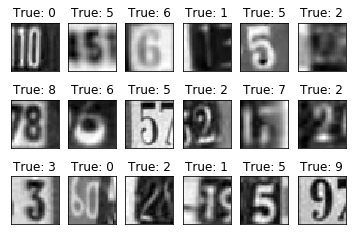


F1 Scores for each class follow:

[(0, 0.878), (1, 0.933), (2, 0.917), (3, 0.863), (4, 0.903), (5, 0.87), (6, 0.844), (7, 0.902), (8, 0.812), (9, 0.842)]


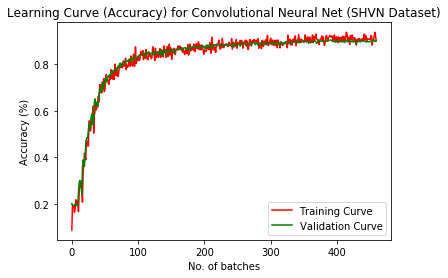

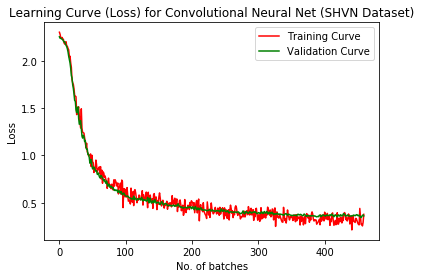

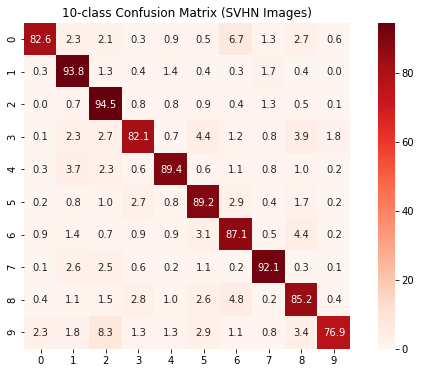

In [39]:
predicted_cls = traintest()

In [52]:
def test(filename, prediction_cls):
    """Test function for pre-trained CNN.
    
    Input: Test image (32x32 pixels (.png))
    Output: Returns integer corresponding to model prediction of house number.
    """
    # imageio.imsave('data/outfile.png', X_test[0])
    # Read in image
    im = imageio.imread('data/' + filename + '.png')
    # View test image
    fig, axes = plt.subplots(1,1)
    axes.imshow(im, cmap='binary')
    # Format image so that it has the right dimensions in the tensorflow model.
    new_list = []
    for row in im:
        new_list.append([[x] for x in row])
    im = np.array([new_list])
    # Start a new session
    sess=tf.Session()
    # Import the pretrained saved model graph and variables using meta and checkpoint files.
    new_saver = tf.train.import_meta_graph('checkpnts/svhn_single_greyscale.meta')
    new_saver.restore(sess, tf.train.latest_checkpoint('checkpnts/'))
    # Specify the test image and label (the label is for comparison with prediction)
    X_test_image = im
    y_test_image = np.array([[0,0,0,0,0,1,0,0,0,0]])
    graph = tf.get_default_graph()
    # Get the operations necessary for predicting the class of the test image
    loss = graph.get_tensor_by_name('loss:0')
    test_loss = sess.run(loss, feed_dict={'Input_Data:0': X_test_image, 'Input_Labels:0': y_test_image})
    prediction = sess.run(prediction_cls, feed_dict={'Input_Data:0': X_test_image})
    # Predicted vs. actual
    print('\nPre-trained Tensorflow CNN predicts number in test image to be: {}\n'.format(prediction[0]))
    # Print the actual number - does it agree with prediction? 
    print ('Actual number is shown in image below:')
    plt.imshow(im[0,:,:,0], cmap='binary')
    return prediction

I0827 18:29:45.826467 4546823616 saver.py:1280] Restoring parameters from checkpnts/svhn_single_greyscale


InvalidArgumentError: You must feed a value for placeholder tensor 'Input_Data_2' with dtype float and shape [?,32,32,1]
	 [[node Input_Data_2 (defined at <ipython-input-30-8b44e0559091>:6) ]]

Original stack trace for 'Input_Data_2':
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/kernelapp.py", line 505, in start
    self.io_loop.start()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/platform/asyncio.py", line 132, in start
    self.asyncio_loop.run_forever()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py", line 528, in run_forever
    self._run_once()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/base_events.py", line 1764, in _run_once
    handle._run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/asyncio/events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/ioloop.py", line 758, in _run_callback
    ret = callback()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/stack_context.py", line 300, in null_wrapper
    return fn(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/gen.py", line 1233, in inner
    self.run()
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/gen.py", line 1147, in run
    yielded = self.gen.send(value)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tornado/gen.py", line 326, in wrapper
    yielded = next(result)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel/zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2819, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2845, in _run_cell
    return runner(coro)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3020, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3185, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-39-9123522daf9b>", line 1, in <module>
    predicted_cls = traintest()
  File "<ipython-input-38-76669cbdb863>", line 6, in traintest
    x, y, y_cls, discard_rate = create_placeholders(X_train)
  File "<ipython-input-30-8b44e0559091>", line 6, in create_placeholders
    x = tf.placeholder(tf.float32, shape = [None, 32, 32, 1], name='Input_Data')
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/array_ops.py", line 2143, in placeholder
    return gen_array_ops.placeholder(dtype=dtype, shape=shape, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/ops/gen_array_ops.py", line 6262, in placeholder
    "Placeholder", dtype=dtype, shape=shape, name=name)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/util/deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 3616, in create_op
    op_def=op_def)
  File "/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/tensorflow/python/framework/ops.py", line 2005, in __init__
    self._traceback = tf_stack.extract_stack()


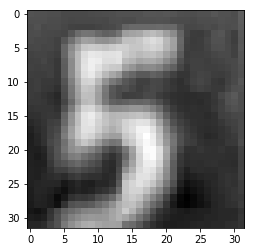

In [54]:
# Run pre-trained model here to predict nunber in image. 
prediction = test('test_image', predicted_cls)

In [73]:
!kill 27318

/bin/sh: pip: command not found
